# Rinse Over Run EDA

By Suzin

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

from IPython.display import display, HTML

pd.set_option('display.max_columns', None)

/Users/suzinyou/anaconda2/envs/biscuit-test/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/suzinyou/anaconda2/envs/biscuit-test/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/suzinyou/anaconda2/envs/biscuit-test/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
from pandas.api.types import CategoricalDtype

In [6]:
df = pd.read_csv(
    "../data/raw/train_values.csv", 
    index_col='row_id', parse_dates=['timestamp'],
    nrows=100000,
)

In [16]:
df.columns

Index(['process_id', 'object_id', 'phase', 'timestamp', 'pipeline',
       'supply_flow', 'supply_pressure', 'return_temperature',
       'return_conductivity', 'return_turbidity', 'return_flow', 'supply_pump',
       'supply_pre_rinse', 'supply_caustic', 'return_caustic', 'supply_acid',
       'return_acid', 'supply_clean_water', 'return_recovery_water',
       'return_drain', 'object_low_level', 'tank_level_pre_rinse',
       'tank_level_caustic', 'tank_level_acid', 'tank_level_clean_water',
       'tank_temperature_pre_rinse', 'tank_temperature_caustic',
       'tank_temperature_acid', 'tank_concentration_caustic',
       'tank_concentration_acid', 'tank_lsh_caustic', 'tank_lsh_acid',
       'tank_lsh_clean_water', 'tank_lsh_pre_rinse', 'target_time_period'],
      dtype='object')

In [7]:
for col in df.columns:
    if df[col].dtype == np.object:
        df.loc[:, col] = df[col].astype('category')

In [10]:
phase_categorical = CategoricalDtype(
    categories=['pre_rinse', 'caustic', 'intermediate_rinse', 
                'acid', 'final_rinse'],
    ordered=True
)
df.phase = df.phase.astype(phase_categorical)

df.phase, phase_mapping_idx = df.phase.factorize()

In [44]:
df.pipeline.cat.categories

Index(['L1', 'L10', 'L11', 'L2', 'L3', 'L4', 'L6', 'L7', 'L8'], dtype='object')

Some of the boolean columns were read as float, but that's fine.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 35 columns):
process_id                    100000 non-null int64
object_id                     100000 non-null int64
phase                         100000 non-null category
timestamp                     100000 non-null datetime64[ns]
pipeline                      100000 non-null category
supply_flow                   100000 non-null float64
supply_pressure               100000 non-null float64
return_temperature            100000 non-null float64
return_conductivity           100000 non-null float64
return_turbidity              100000 non-null float64
return_flow                   100000 non-null float64
supply_pump                   100000 non-null bool
supply_pre_rinse              100000 non-null bool
supply_caustic                100000 non-null bool
return_caustic                100000 non-null bool
supply_acid                   100000 non-null bool
return_acid                   100000

We notice that the division in phase isn't completely determined by the valve states. For example, during the pre-rinsing phase, for 0.8% of the time the caustic valve is open, and for 10% of the time none of the valves are open.

In [61]:
df[['phase', 'supply_pre_rinse', 'supply_caustic', 'supply_acid', 'supply_clean_water']].groupby(['phase']).mean()

,supply_pre_rinse,supply_caustic,supply_acid,supply_clean_water
phase,,,,
acid,0.000000,0.000000,0.883297,0.014974
caustic,0.000000,0.890333,0.000000,0.006128
final_rinse,0.000000,0.000000,0.000000,0.560907
intermediate_rinse,0.000000,0.000000,0.037583,0.551221
pre_rinse,0.883571,0.007619,0.000000,0.000000


But also that two valves are never open at the same time.

In [54]:
(
    (df.supply_pre_rinse) & (df.supply_caustic)
).sum(), (
    (df.supply_acid) & (df.supply_clean_water)
).sum(), (
    (df.supply_acid) & (df.supply_clean_water)
).sum()  # other combos are also 0

(0, 0, 0, 0)

In [32]:
pd.crosstab(df['phase'], df['tank_lsh_pre_rinse'])

tank_lsh_pre_rinse,0.0
phase,
acid,23307
caustic,37696
final_rinse,24291
intermediate_rinse,6306
pre_rinse,8400


`target_time_period` column seemed a little confusing. From the [competition description](https://www.drivendata.org/competitions/56/predict-cleaning-time-series/page/125/):
> `target_time_period` - Indicator (Boolean) of if the observation is included when calculating the target variable.

So only if `target_time_period` is `True` does that row count towards the target variable, `final_rinse_total_turbidity_liter`. Not all of the final rinse phase count.

In [64]:
df[(df.process_id == 20001) & (df.target_time_period == False)].tail(2)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1460,20001,405,final_rinse,2018-04-15 05:09:27,L4,53193.720,1.912109,70.88397,32.577740,0.437645,52394.383,True,False,False,False,False,True,True,False,False,True,55.61722,40.650860,42.240128,42.228370,33.47801,82.84867,72.80093,45.742397,44.653038,False,0.0,False,0.0,False
1461,20001,405,final_rinse,2018-04-15 05:09:29,L4,53631.367,1.900825,70.05208,12.576046,0.383391,53092.450,True,False,False,False,False,True,True,False,False,True,55.61722,40.646156,42.240128,42.221317,33.47801,82.84867,72.80093,45.735096,44.653038,False,0.0,False,0.0,False


In [65]:
df[(df.process_id == 20001) & (df.target_time_period == True)].head(2)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1462,20001,405,final_rinse,2018-04-15 05:09:31,L4,53765.190,1.904731,67.31770,7.588104,0.325521,52944.152,True,False,False,False,False,False,True,True,False,True,55.61722,40.641457,42.240128,42.20721,33.478010,82.85229,72.80093,45.728832,44.653038,False,0.0,False,0.0,True
1463,20001,405,final_rinse,2018-04-15 05:09:33,L4,53909.867,1.905165,62.64106,4.625165,0.311053,53530.090,True,False,False,False,False,False,True,True,False,True,55.61722,40.639107,42.240128,42.18370,33.459927,82.84867,72.80093,45.728450,44.653038,False,0.0,False,0.0,True


Let's figure out how to shape this data for RNNs. First, let's see how long each sequence is.

In [12]:
pid_lengths = [len(df[df.process_id == pid]) for pid in df.process_id.unique()]

<IPython.core.display.Javascript object>


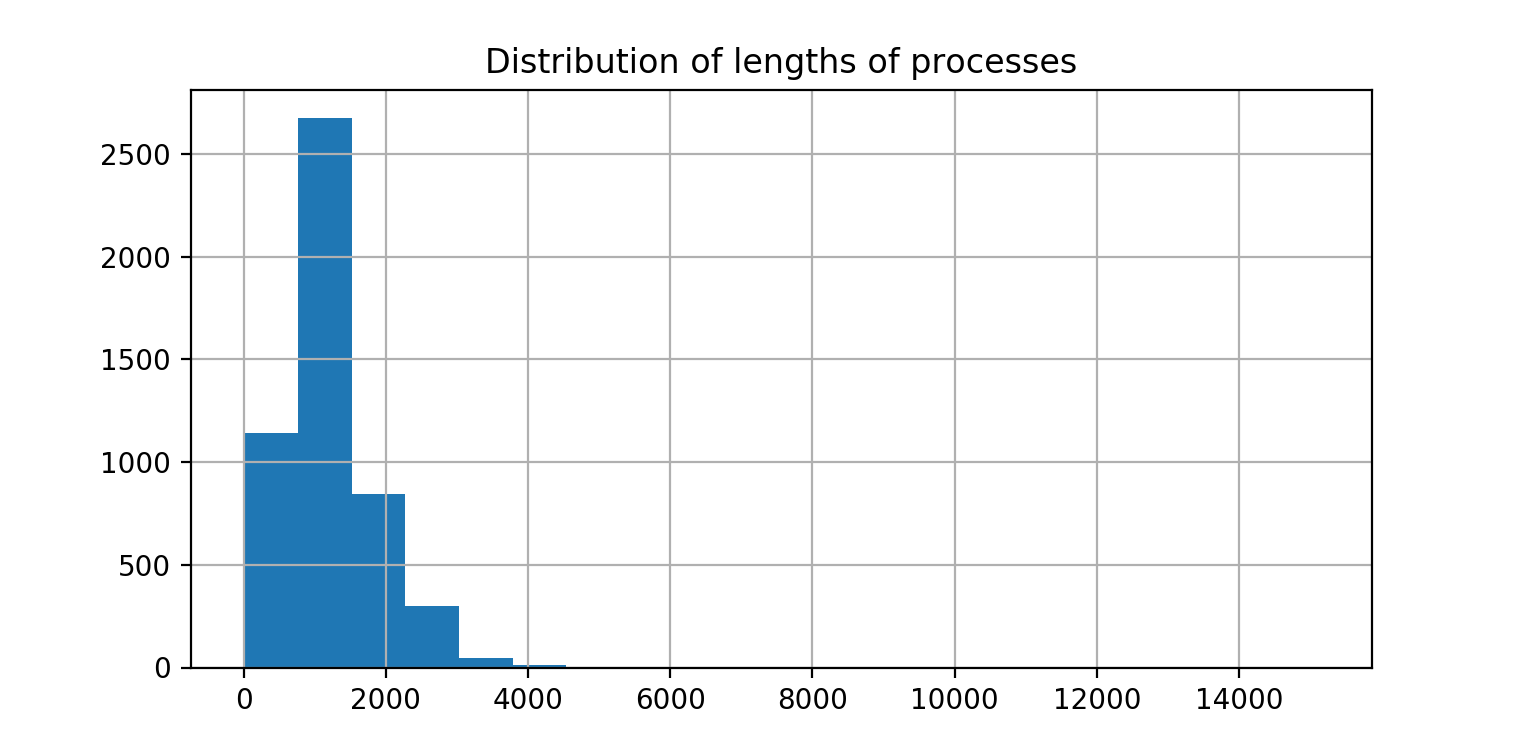

[]

In [13]:
plt.figure()
plt.title("Distribution of lengths of processes")
pd.Series(pid_lengths).hist(bins=20)
plt.plot()

In [14]:
min(pid_lengths), max(pid_lengths)

(9, 15107)

We should inspect unusally short sequences.

In [19]:
np.argsort(np.array(pid_lengths))[:10]

array([ 986, 1115,  742, 4810, 3554, 4383, 2292, 2223, 2069,  212])

In [22]:
df.process_id.unique()[[ 986, 1115,  742, 4810, 3554, 4383, 2292, 2223, 2069,  212]]

array([21637, 21833, 21216, 27676, 25683, 27008, 23756, 23644, 23370,
       20341])

Insert the `process_id`'s above below to see examples:

In [34]:
df[df.process_id == 21637]

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1198748,21637,405,final_rinse,2018-02-24 11:28:05,L4,2886.2847,0.174479,17.136864,6.819815,0.690828,-220.63078,False,True,False,False,False,False,False,False,True,True,57.810690,39.832718,43.812935,32.960793,24.457464,81.108940,72.146260,45.046352,44.013718,False,0.0,False,0.0,True
1198749,21637,405,final_rinse,2018-02-24 11:28:07,L4,8221.2100,0.174696,17.158566,6.812457,0.705295,-701.67820,True,True,False,False,False,False,False,False,True,True,57.815395,39.830368,43.812935,32.986656,24.457464,81.112560,72.073930,45.057655,44.106636,False,0.0,False,0.0,True
1198750,21637,405,final_rinse,2018-02-24 11:28:09,L4,11512.5870,0.174696,17.180265,6.633506,0.723380,372.54050,True,True,False,False,False,False,False,False,True,True,57.815395,39.837420,43.817640,32.998410,24.457464,81.090860,72.019680,45.074646,44.227386,False,0.0,False,0.0,True
1198751,21637,405,final_rinse,2018-02-24 11:28:11,L4,13093.1720,0.174696,17.220050,6.707878,0.723380,766.78240,True,True,False,False,False,False,False,False,True,True,57.817745,39.830368,43.817640,33.017216,24.457464,81.090860,72.077545,45.080914,44.287247,False,0.0,False,0.0,True
1198752,21637,405,final_rinse,2018-02-24 11:28:13,L4,11042.3900,0.174696,17.263454,6.766002,0.737847,36.16898,True,True,False,False,False,False,False,False,True,True,57.817745,39.835068,43.819984,33.047780,24.457464,81.090860,72.160736,45.092167,44.389840,False,0.0,False,0.0,True
1198753,21637,405,final_rinse,2018-02-24 11:28:15,L4,25546.1520,0.174696,17.252605,6.740618,0.694445,-426.79400,False,False,False,False,False,False,False,False,True,True,57.810690,39.839770,43.817640,33.061886,24.457464,81.130640,72.301796,45.098003,44.482630,False,0.0,False,0.0,True
1198754,21637,405,final_rinse,2018-02-24 11:28:17,L4,22978.1520,0.174696,17.223670,6.713376,0.687211,-184.46180,False,False,False,False,False,False,False,True,False,True,57.815395,39.837420,43.819984,33.073640,24.457464,81.130640,72.403070,45.103836,44.566418,False,0.0,False,0.0,True
1198755,21637,405,final_rinse,2018-02-24 11:28:19,L4,11168.9810,0.174696,17.241755,5.410214,1.359954,-1247.82980,False,False,False,False,False,False,False,False,False,True,57.817745,39.844470,43.810580,33.092445,24.457464,81.130640,72.453705,45.103058,44.648567,False,0.0,False,0.0,True
1198756,21637,405,final_rinse,2018-02-24 11:28:21,L4,6022.1357,0.174696,17.415363,23.068579,3.374566,-1247.82980,False,False,False,False,False,False,False,False,False,False,57.820100,39.830368,43.812935,33.113610,24.457464,81.170425,72.497110,45.108856,44.786057,False,0.0,False,0.0,True


Upon inspection, we see that some processes only have `final_rinse` informtaion. Not only that, some of them don't even have any data where `target_time_period == False`.

We should probably remove those processes since
1. We can't predict if there is no training data!
2. In the test set, none of the sequences include `final_rinse` phase data (at least according to the problem description).

In [35]:
pids_to_drop = []
for pid in df.process_id.unique():
    process_df = df[df.process_id == pid]
    if (process_df.phase == 'final_rinse').all() or process_df.target_time_period.all():
        pids_to_drop.append(pid)

In [36]:
import joblib
joblib.dump(pids_to_drop, "pids_to_drop.pkl")

['pids_to_drop.pkl']

In [37]:
len(pids_to_drop)

16

Now let's figure out how long each phase is.

In [79]:
df.phase.cat.categories

Index(['acid', 'caustic', 'final_rinse', 'intermediate_rinse', 'pre_rinse'], dtype='object')

In [80]:
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid', 'final_rinse']

In [82]:
phase_lengths = dict()
for phase in phases:
    df_phase = df[df.phase == phase]
    phase_lengths[phase] = [len(df_phase[df_phase.process_id == pid]) for pid in df.process_id.unique()]

In [90]:
phase_lengths.keys()

dict_keys(['final_rinse', 'pre_rinse', 'acid', 'intermediate_rinse', 'caustic'])

<IPython.core.display.Javascript object>


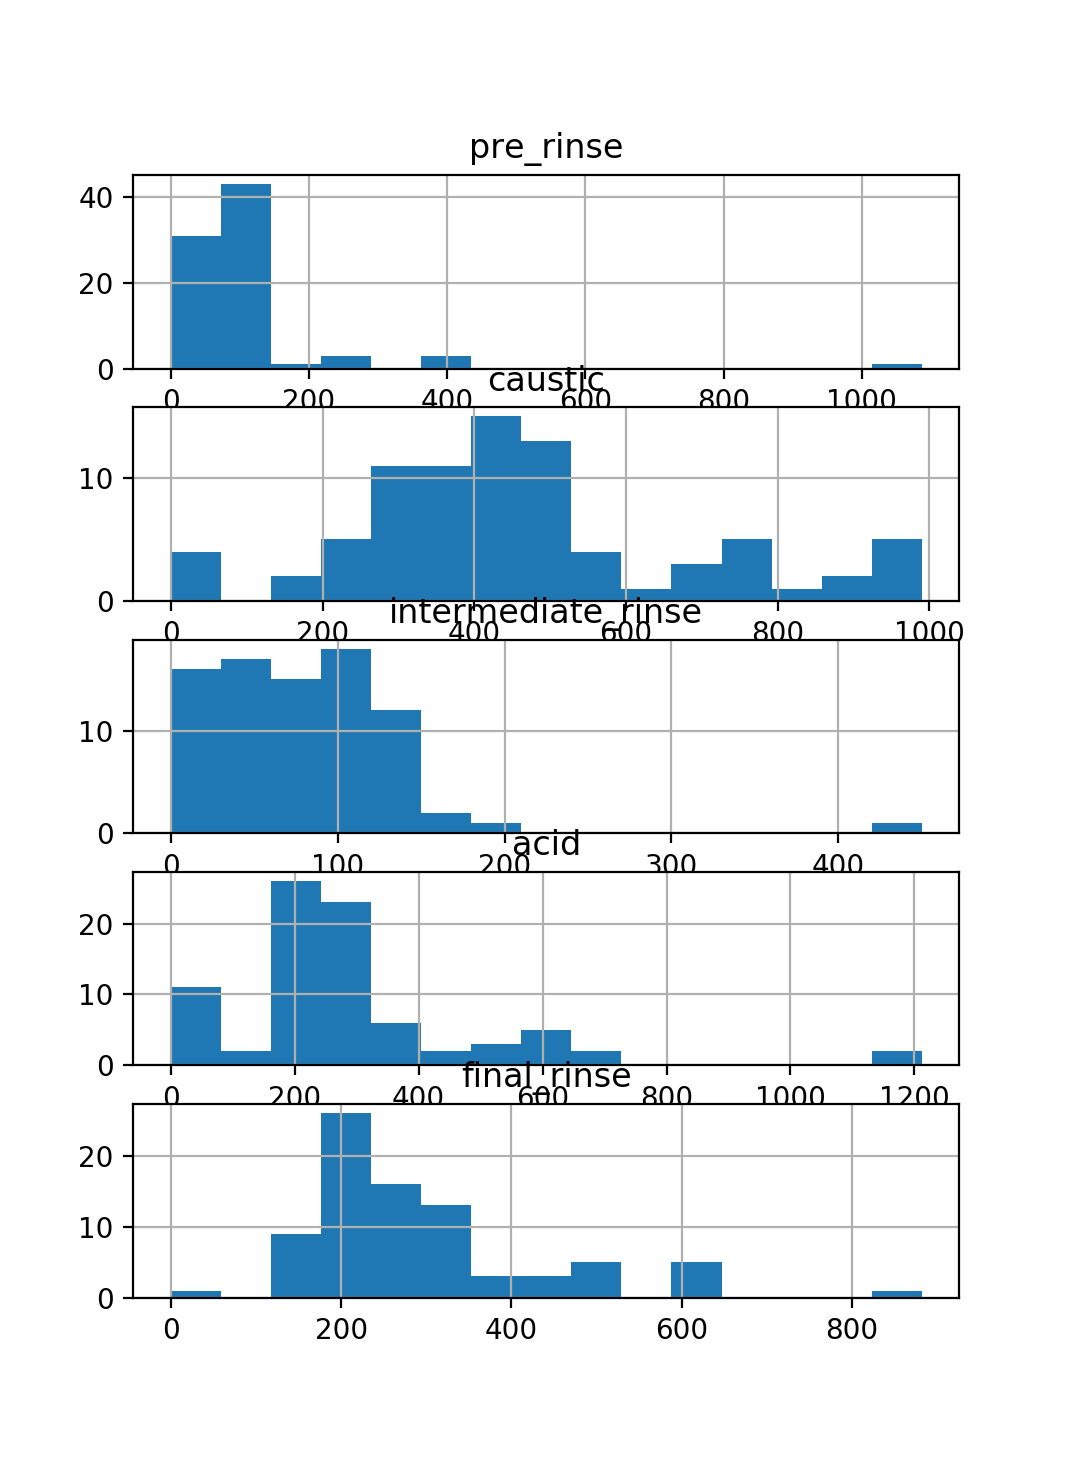

In [97]:
figs, axes = plt.subplots(len(phases))
for i, phase in enumerate(phases):
    pd.Series(phase_lengths[phase]).hist(ax=axes[i], bins=15)
    axes[i].set_title(phase)

We also need to think about how to split train vs. validation sets.

Clearly, inference should not be made using any `final_rinse` data.

Moreover, inference should be validated only on the `final_rinse` data where `target_time_period == True`.

In fact, does any of the `final_rinse` data points matter? This data isn't even available for test dataset. We only need to predict the labels.

Is there some way to use `final_rinse` data for training but not on prediction/testing?
* Maybe it will be beneficial to train the model so that it can also predict `final_turbidity_...` from within `final_rinse`?


## Should we scale it?

Note that most neural networks prefer their input values to be in ~reasonable~ range. Centering and dividing by standard deviation (often called standardizing) should help.

Let's see the distributions of each feature to make sure we need to standardize.

<IPython.core.display.Javascript object>


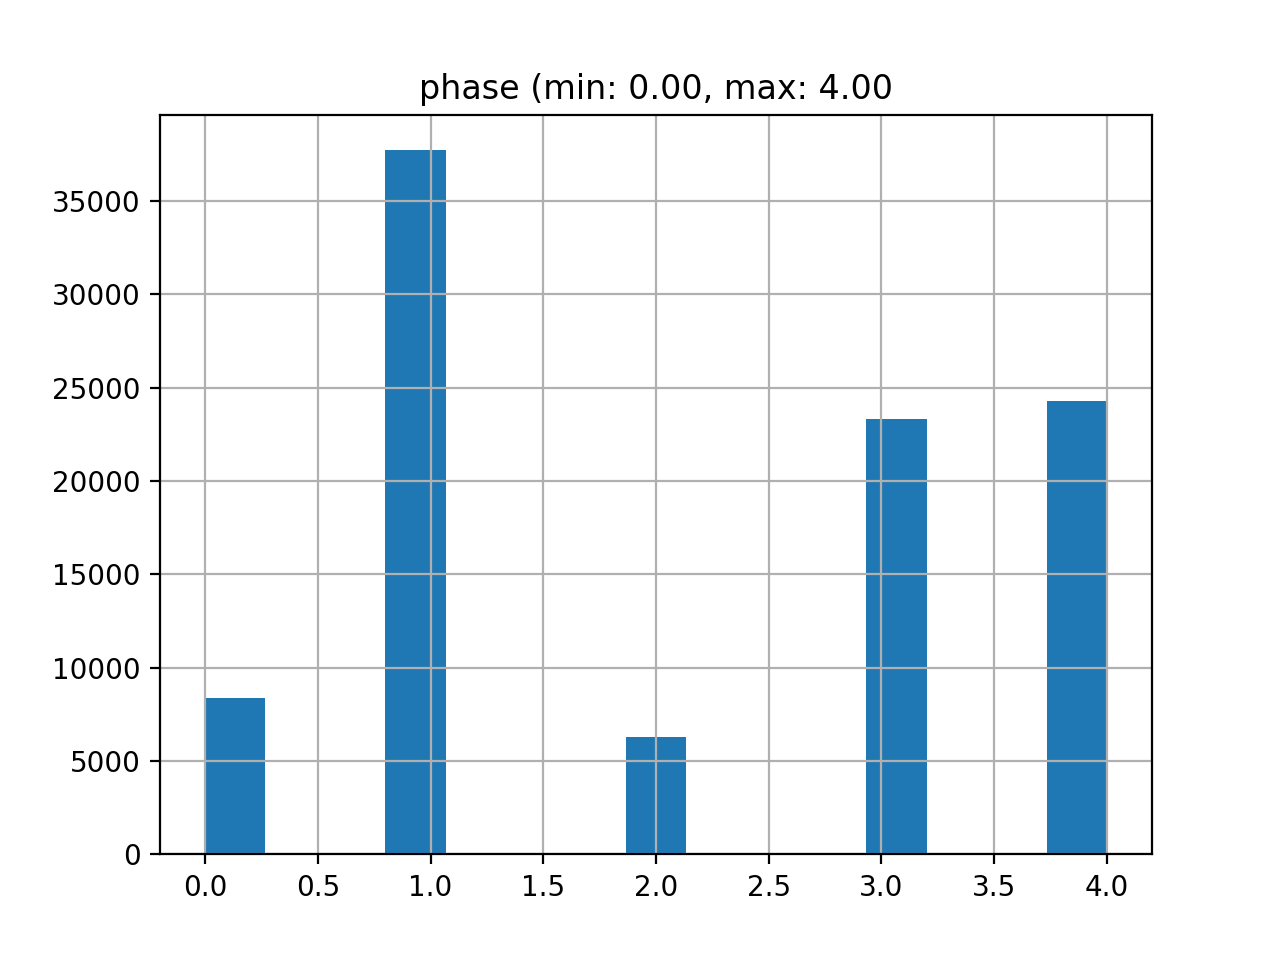

<IPython.core.display.Javascript object>


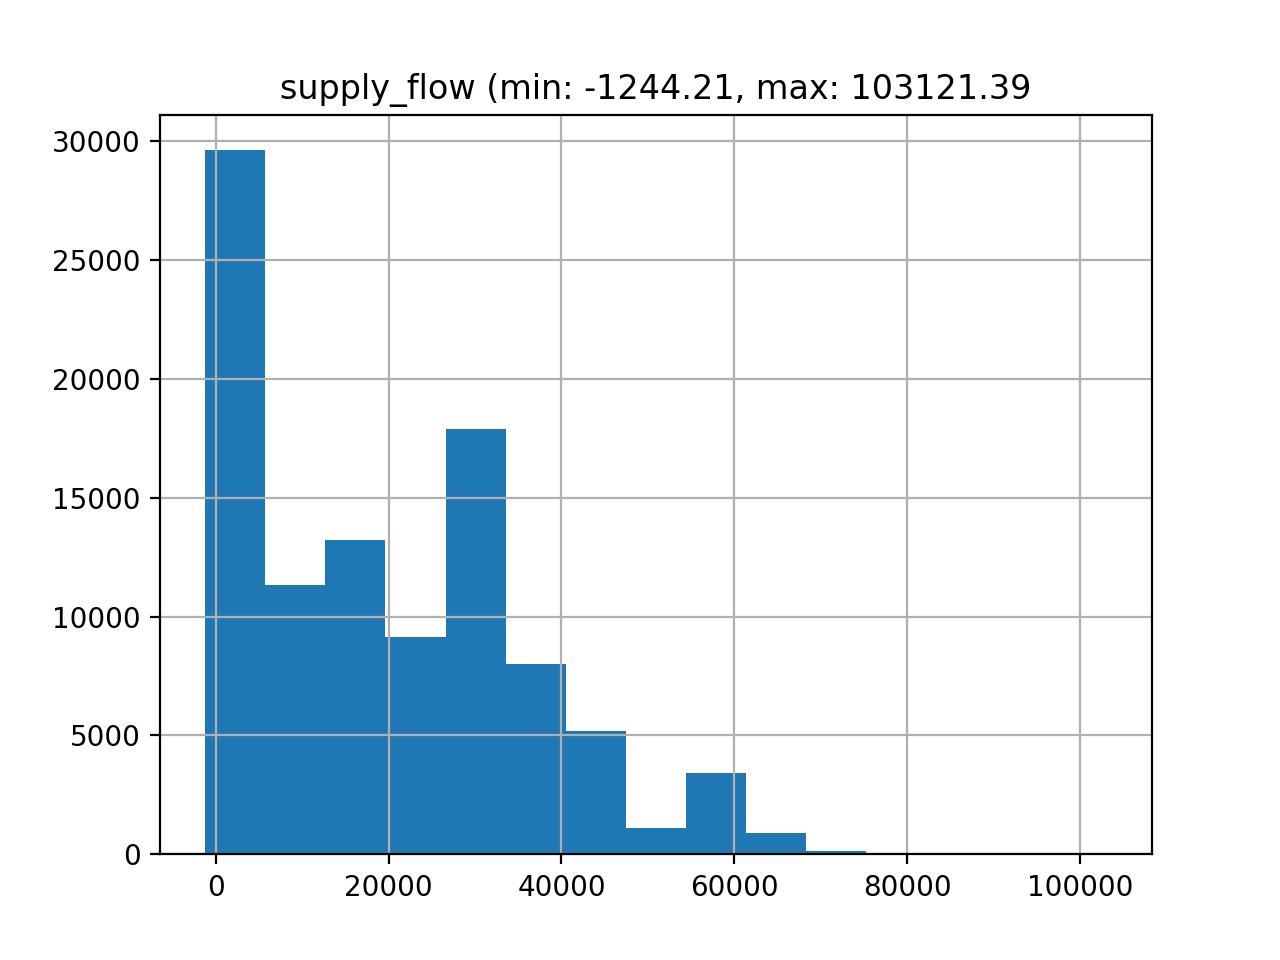

<IPython.core.display.Javascript object>


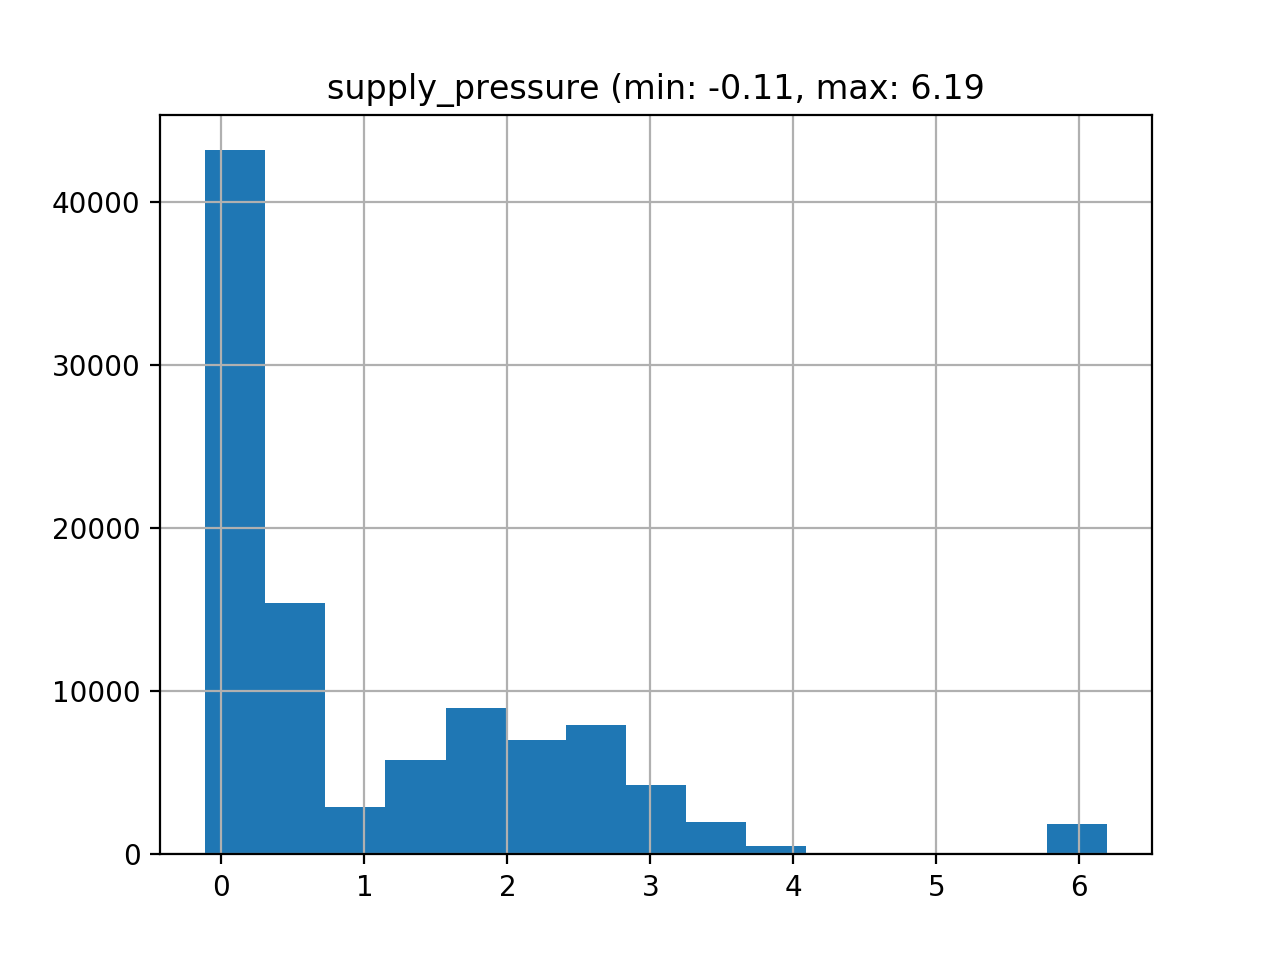

<IPython.core.display.Javascript object>


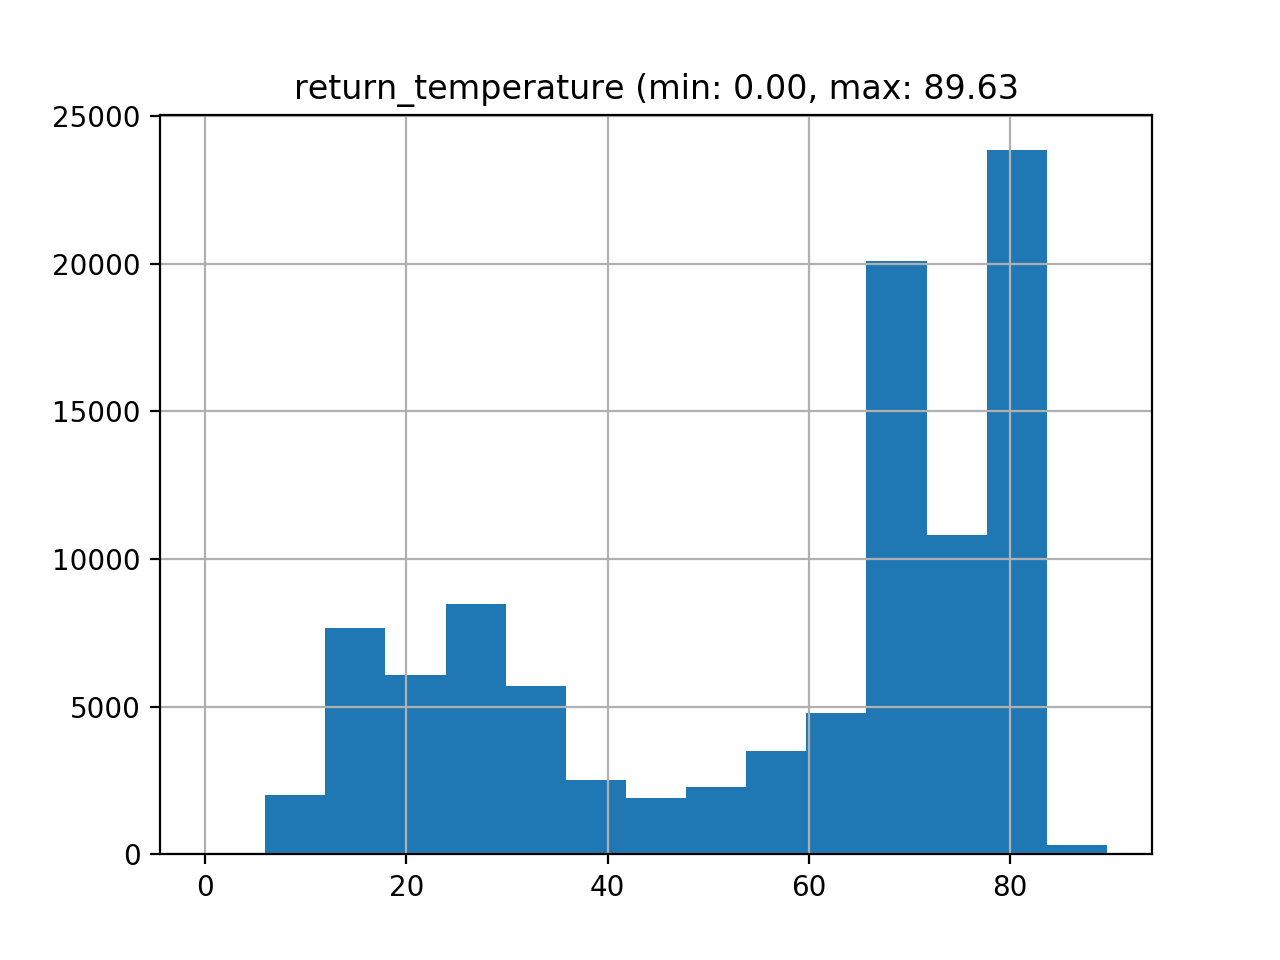

<IPython.core.display.Javascript object>


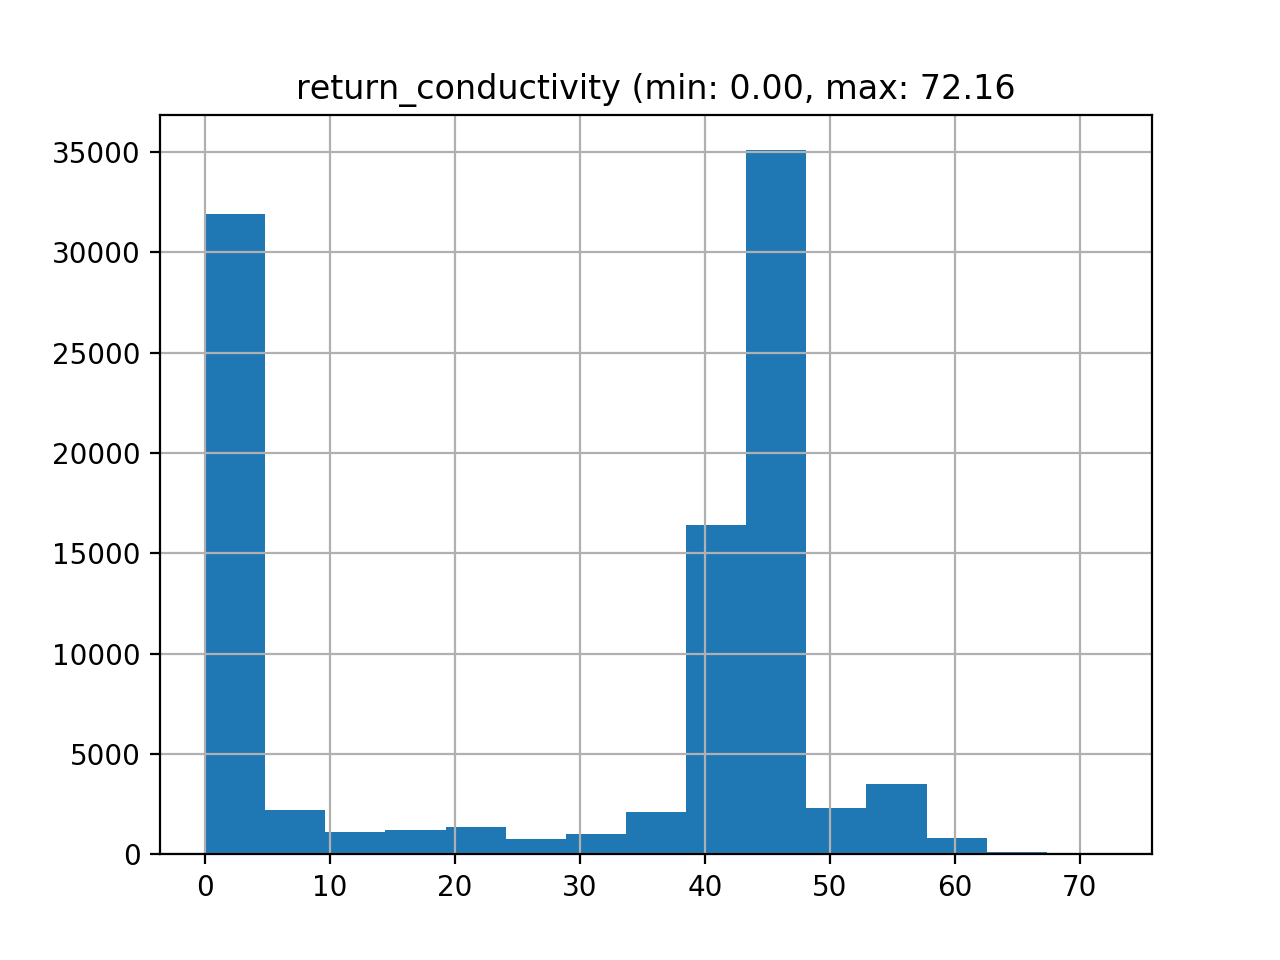

<IPython.core.display.Javascript object>


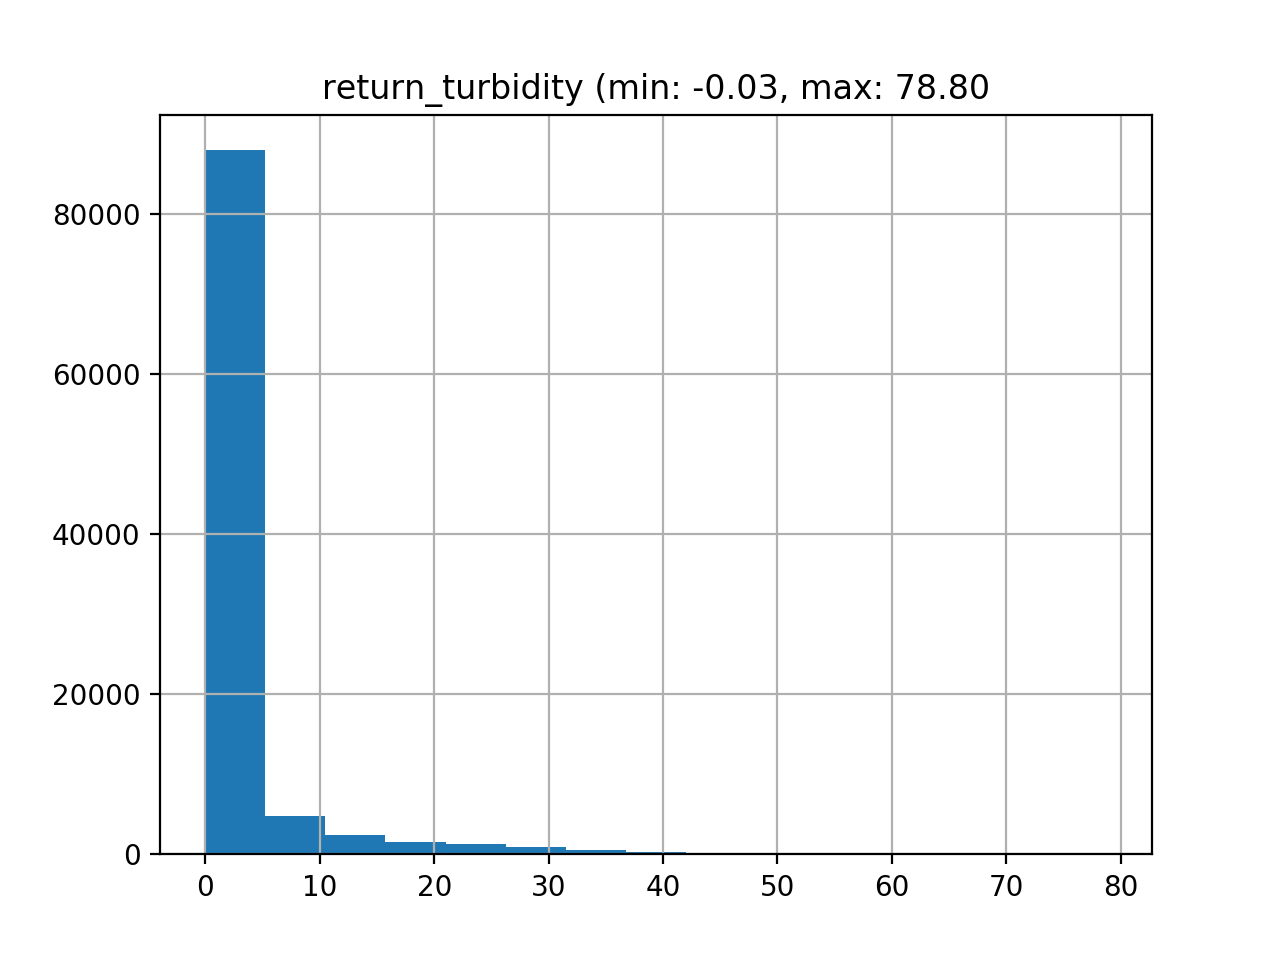

<IPython.core.display.Javascript object>


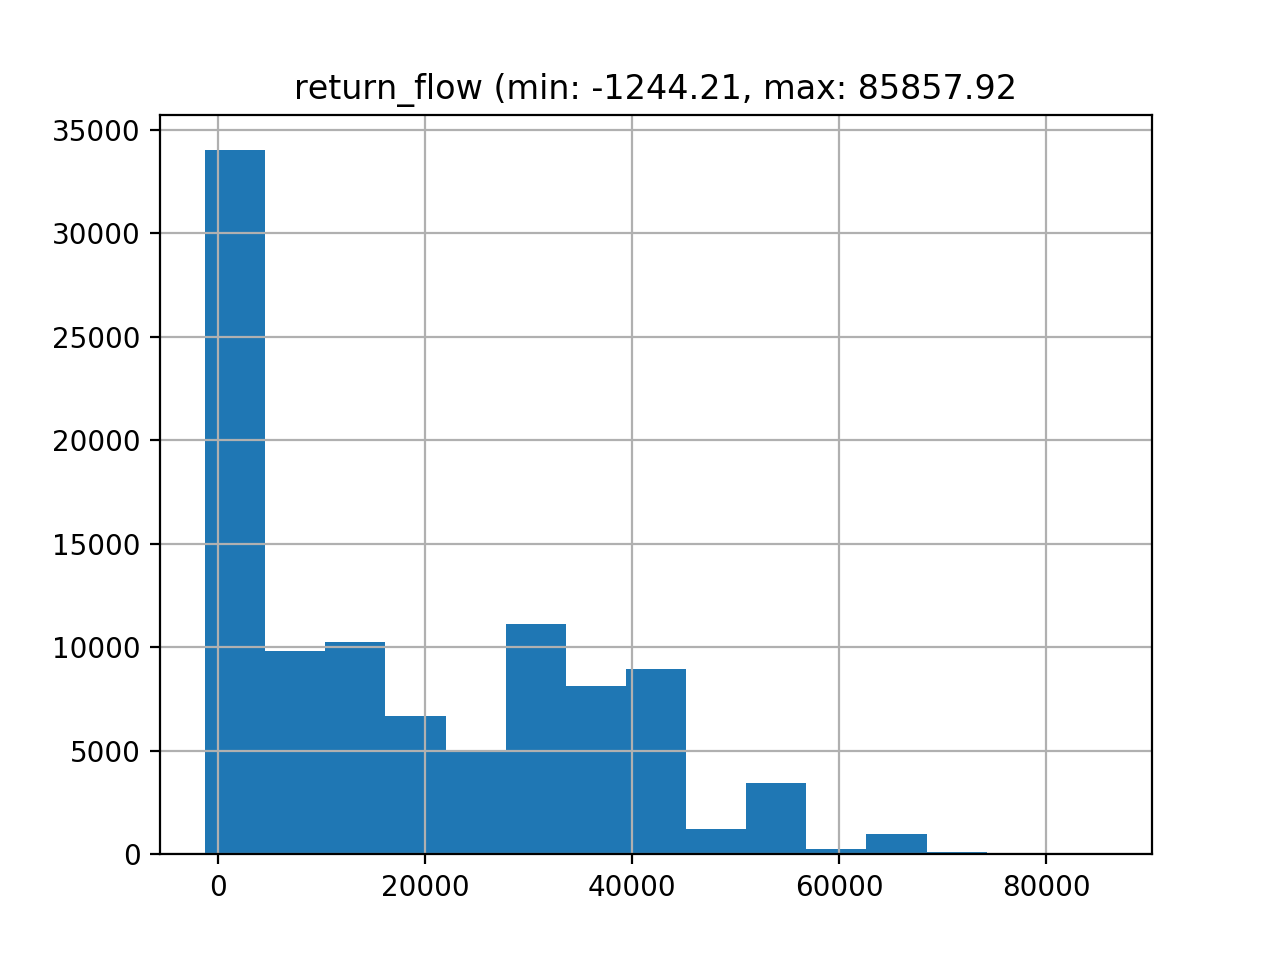

<IPython.core.display.Javascript object>


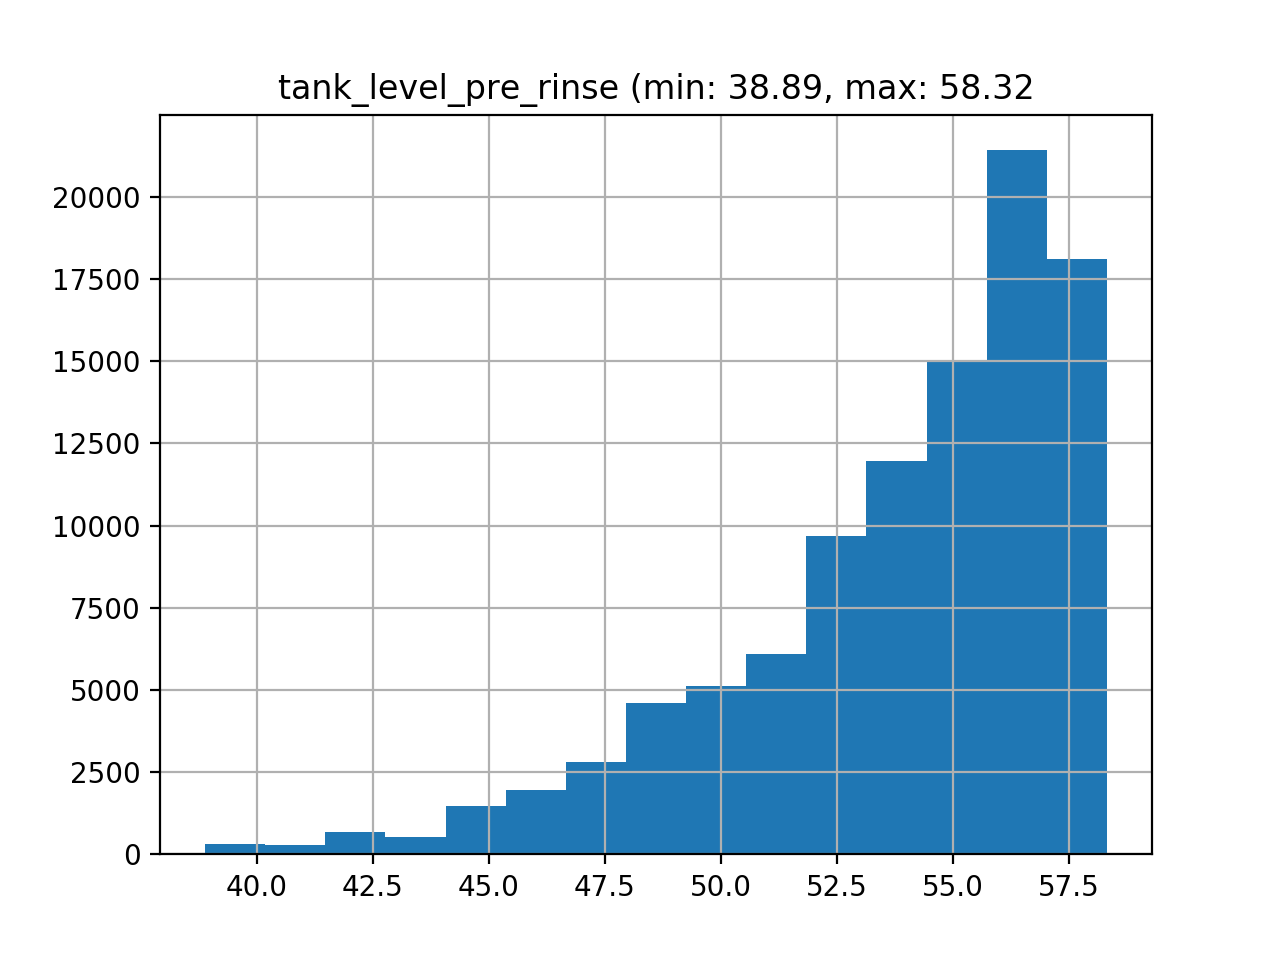

<IPython.core.display.Javascript object>


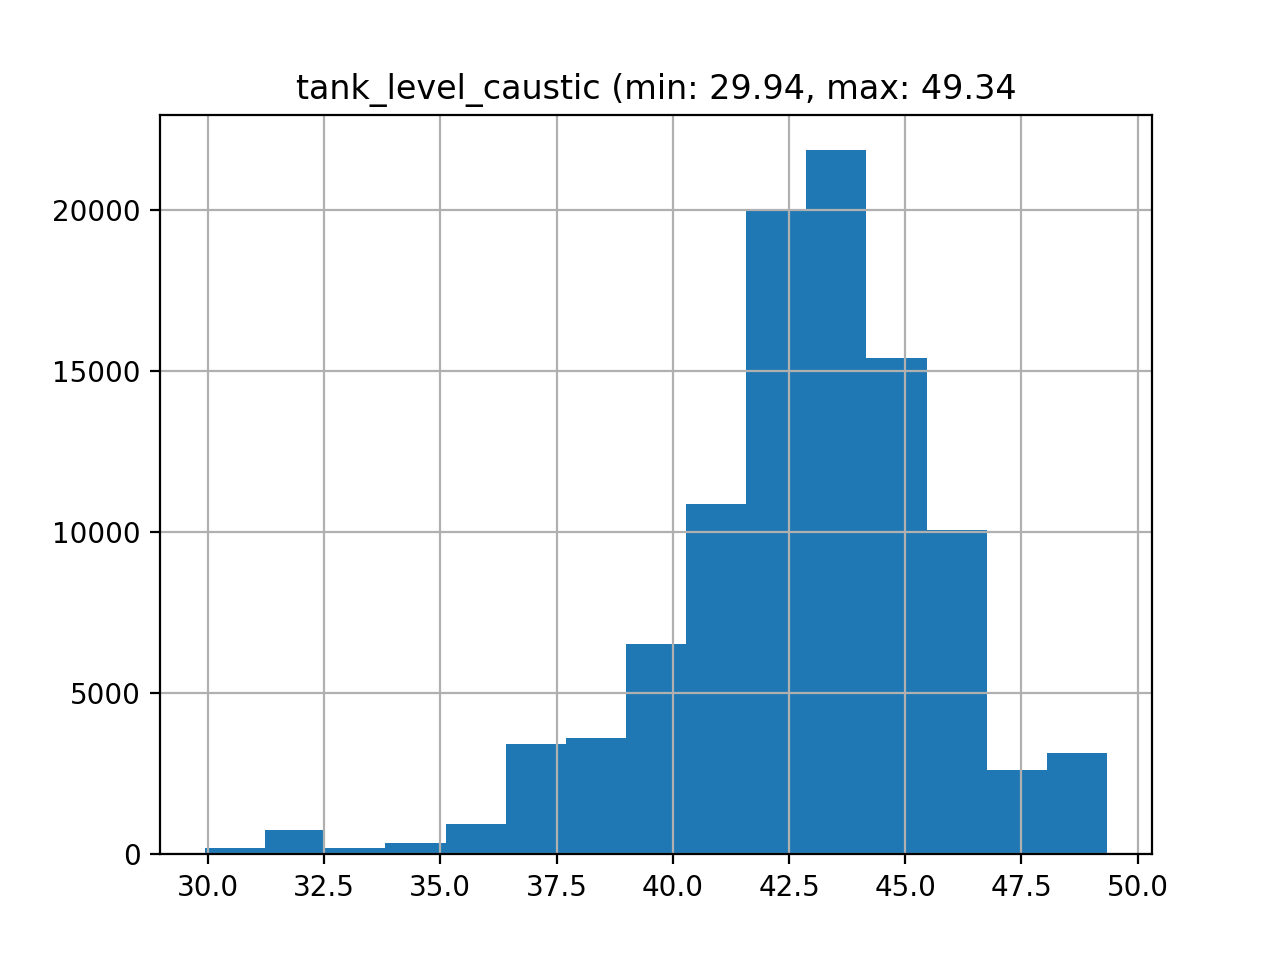

<IPython.core.display.Javascript object>


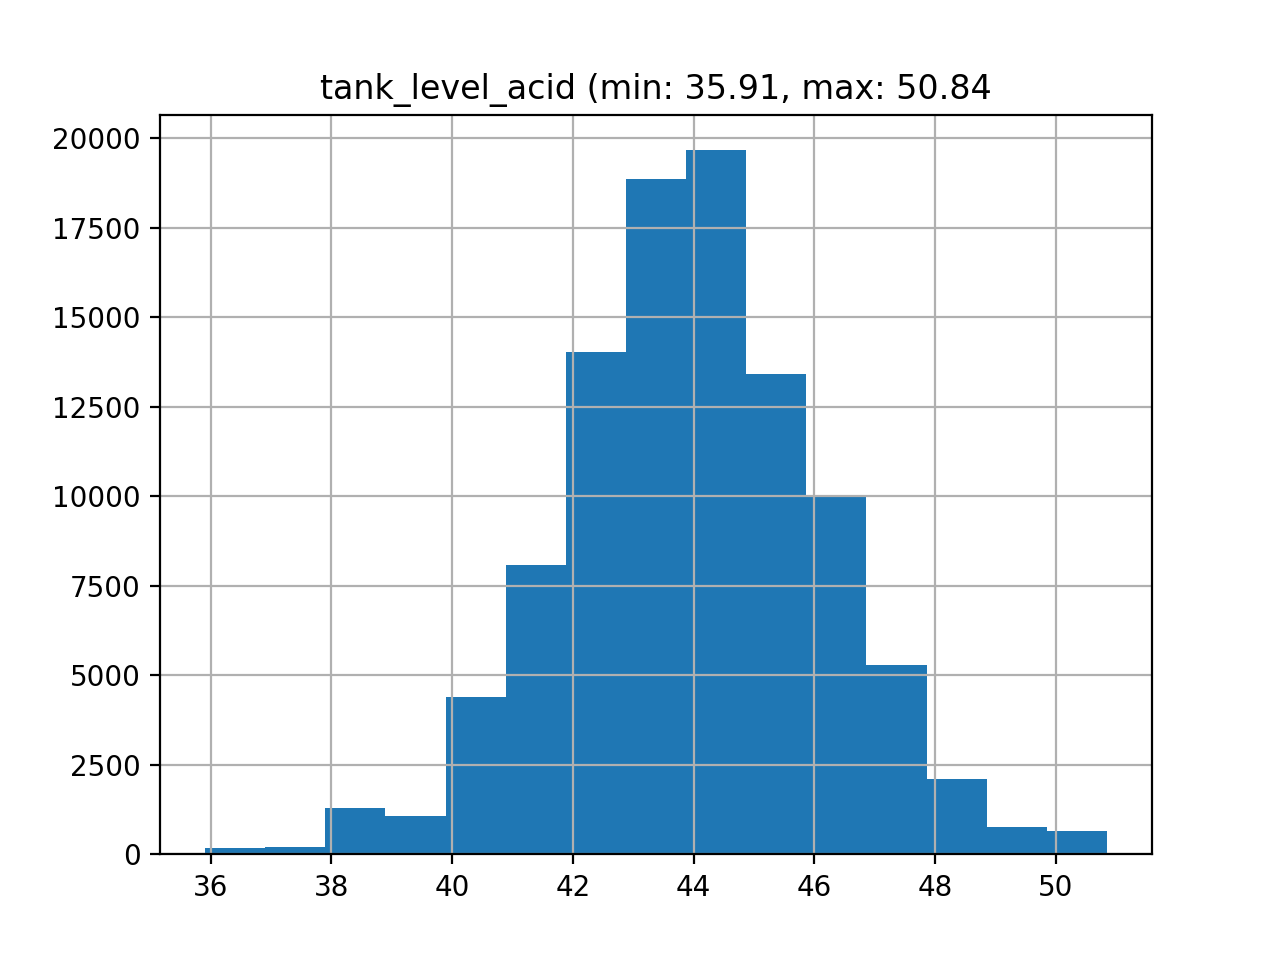

<IPython.core.display.Javascript object>


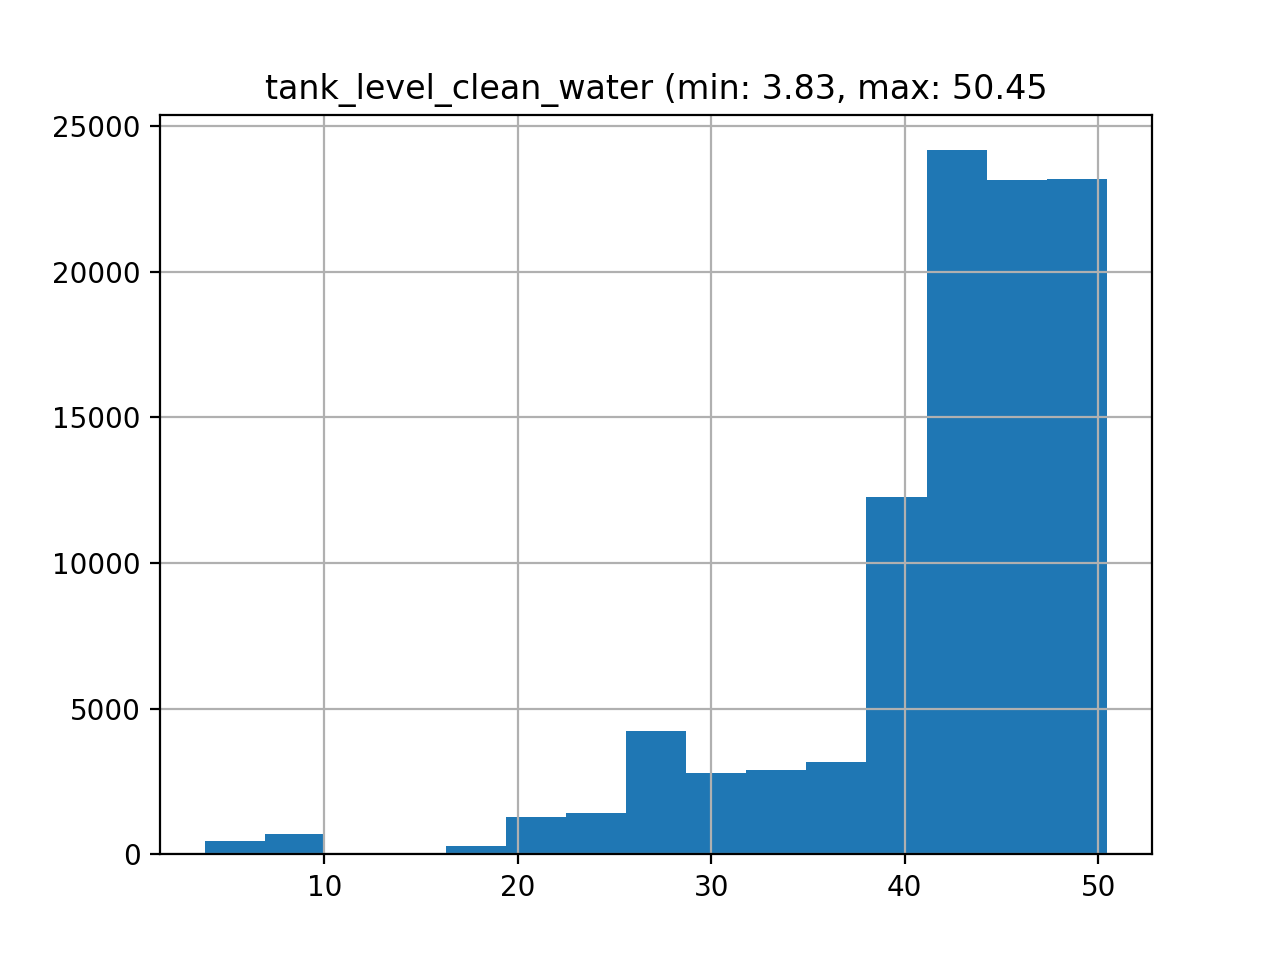

<IPython.core.display.Javascript object>


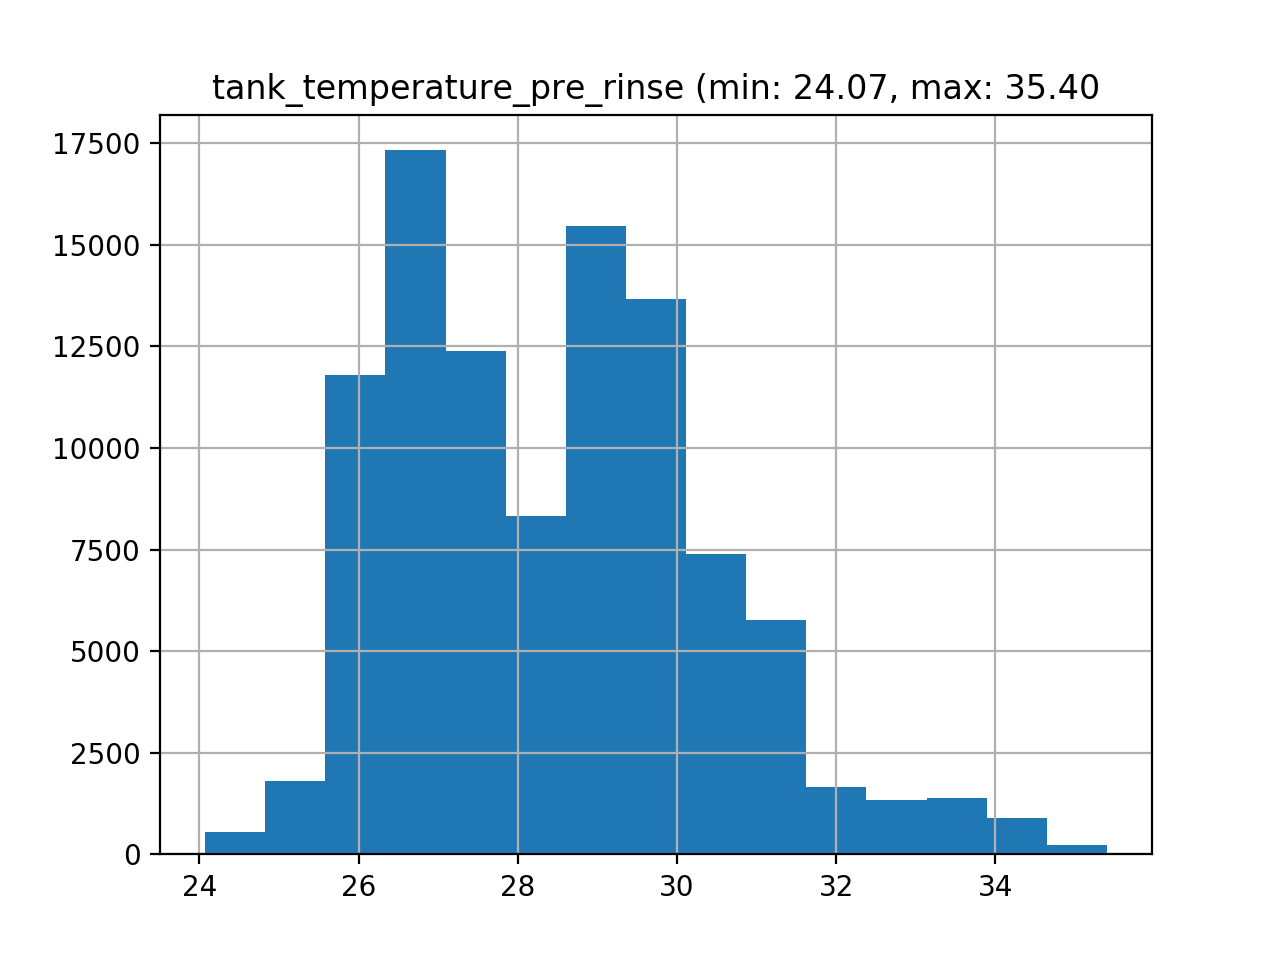

<IPython.core.display.Javascript object>


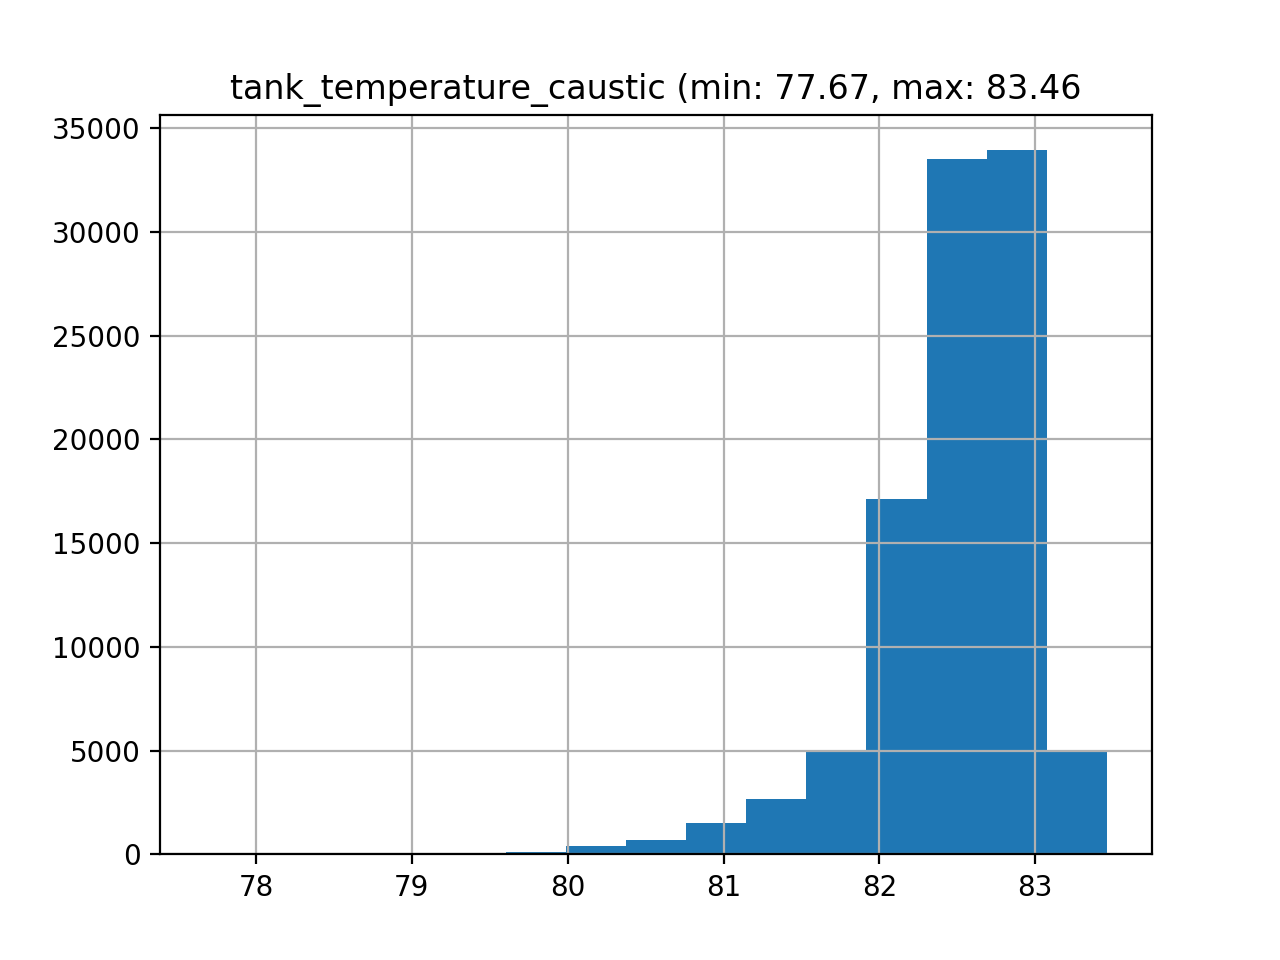

<IPython.core.display.Javascript object>


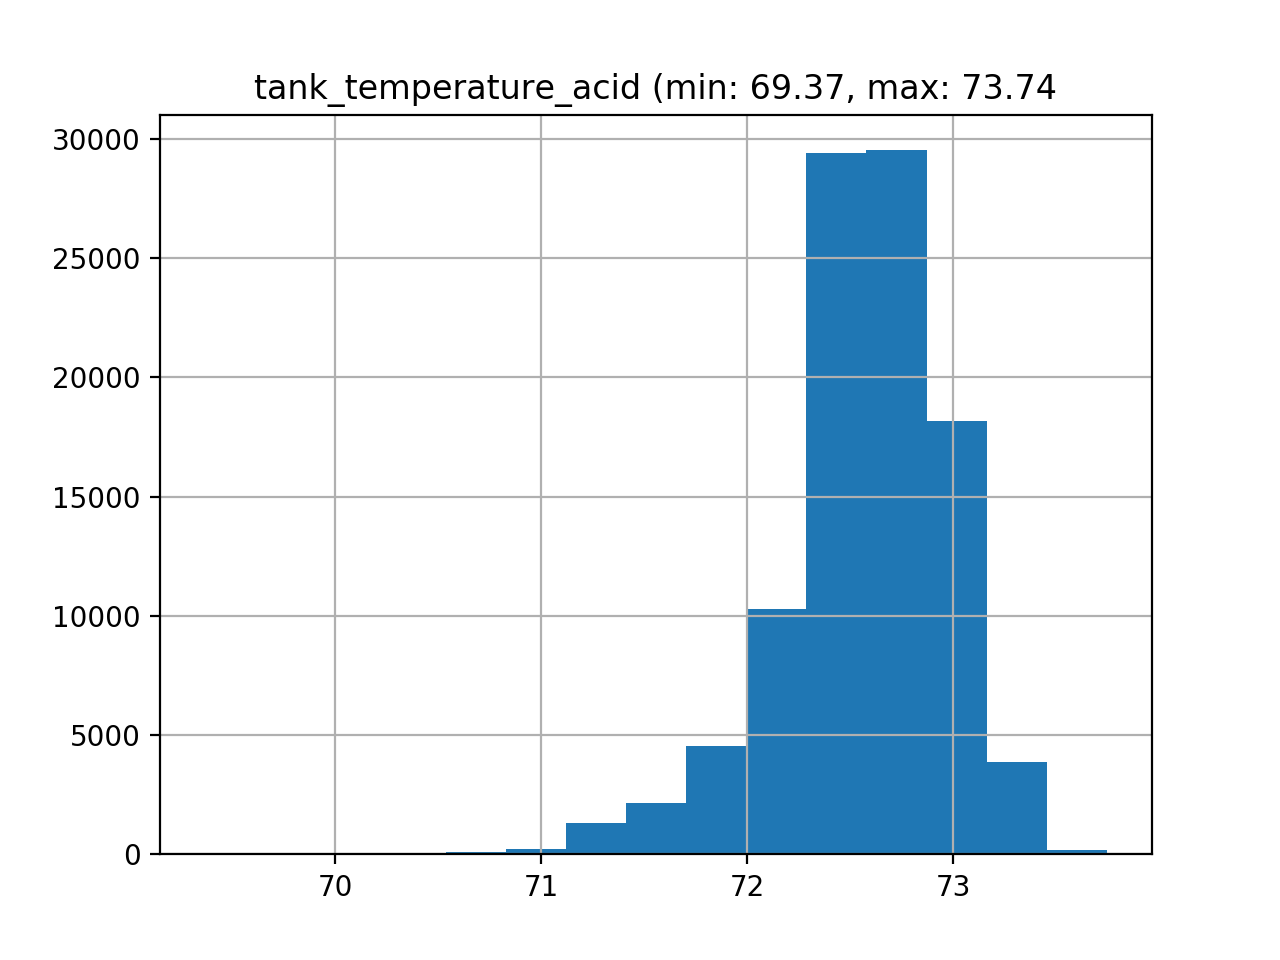

<IPython.core.display.Javascript object>


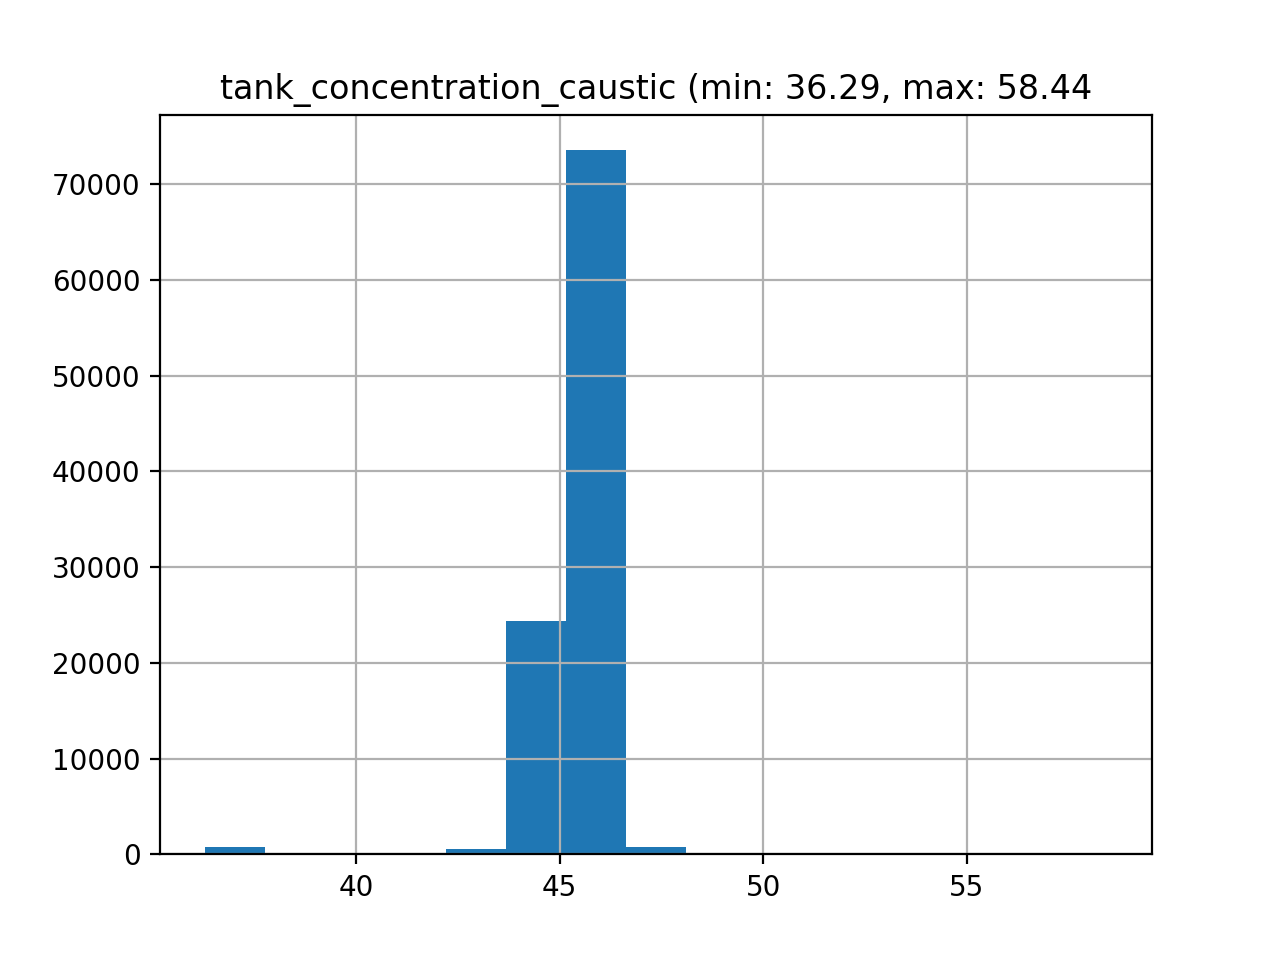

<IPython.core.display.Javascript object>


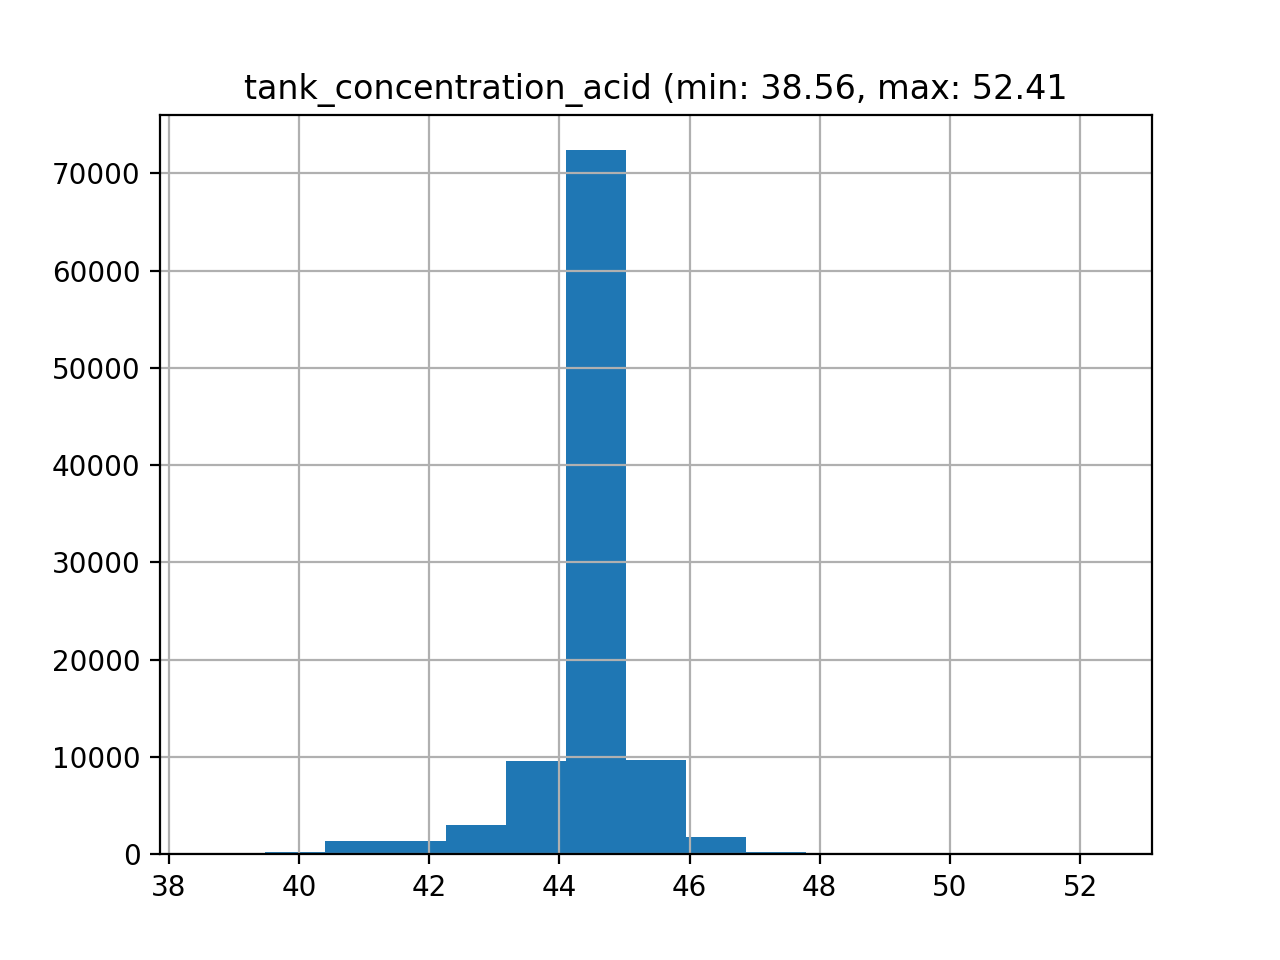

<IPython.core.display.Javascript object>


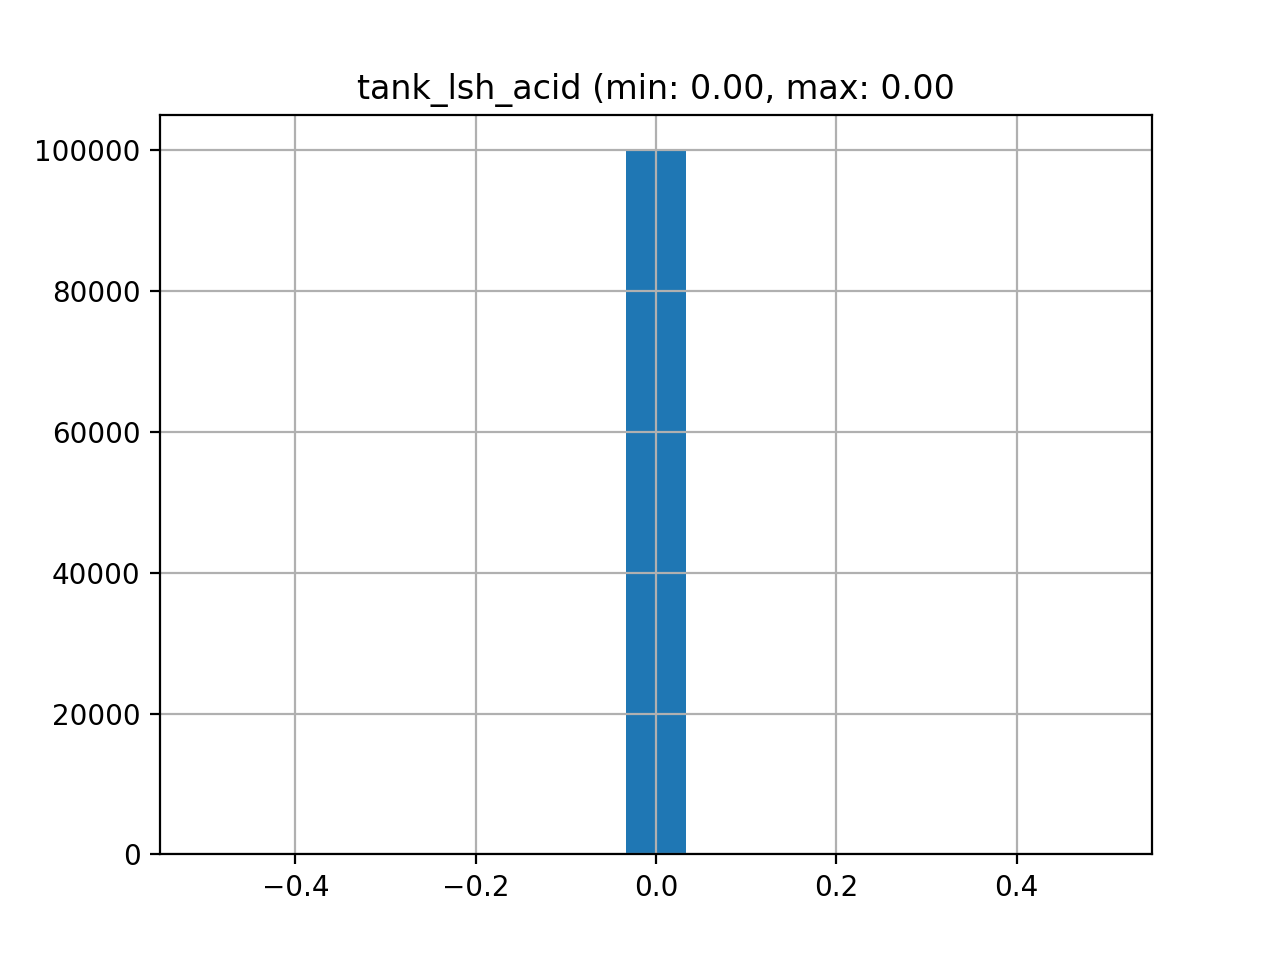

<IPython.core.display.Javascript object>


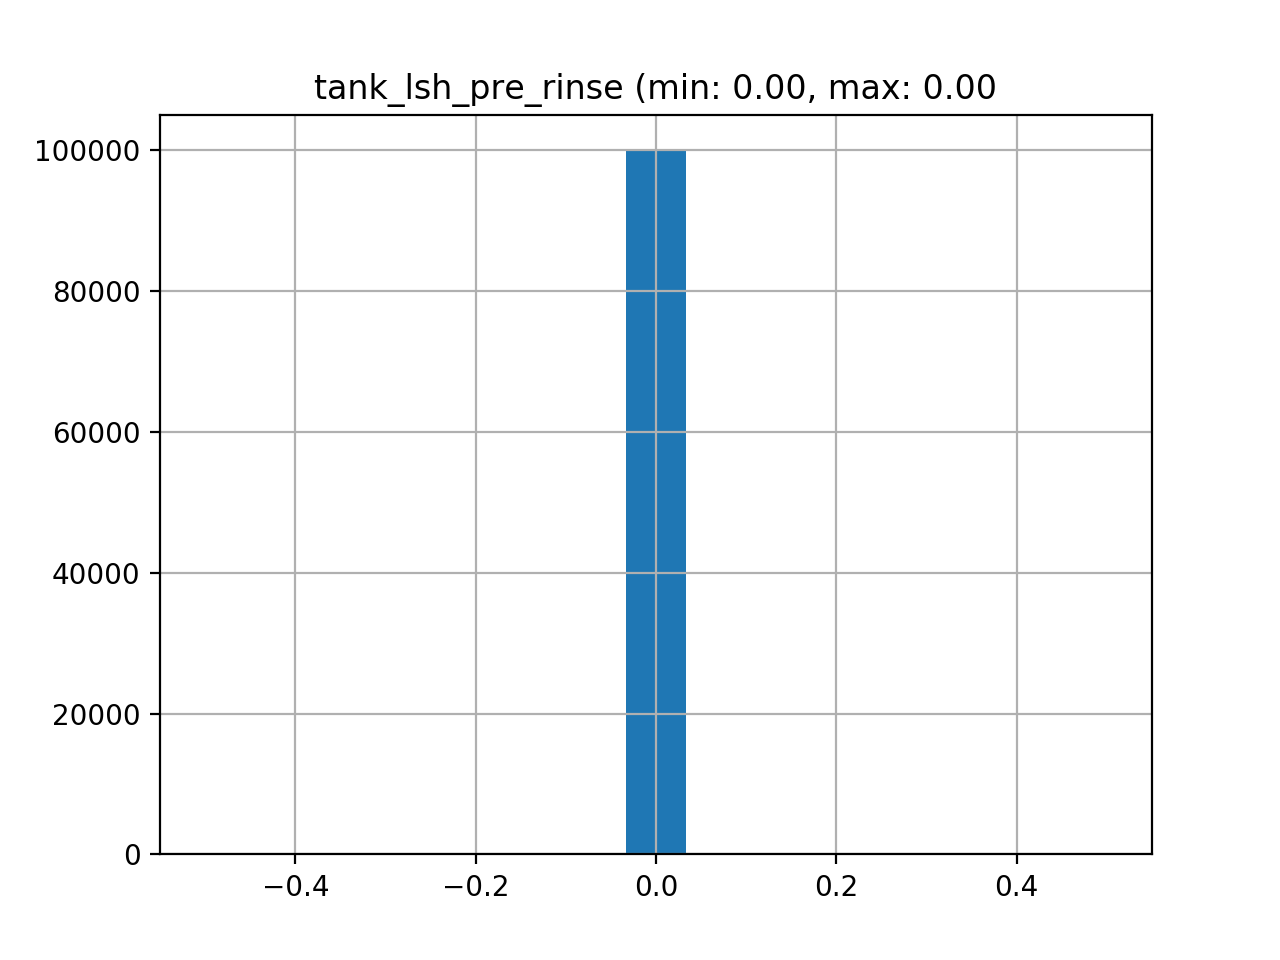

In [15]:
for col in df.columns:
    if df[col].dtype in (float, int) and (
        col not in ['process_id', 'object_id', 'pipeline', 'phase']
    ):
        plt.figure()
        plt.title(
            "{col} (min: {min:.2f}, max: {max:.2f})".format(
                col=col, min=df[col].min(), max=df[col].max()))
        df[col].hist(bins=15)
        plt.show()